In [1]:
%matplotlib inline

import numpy
import os
import seaborn
from matplotlib import pyplot as plt

seaborn.set_palette('deep', color_codes=True)
plt.ion()

# Change these paths to point to the location of your data
TABLES_DIR = '../../data/tables/'
os.chdir(TABLES_DIR)

# Catalogue data and SQL

:::{important}
This sections is a work in progress. New content will be added shortly.
:::

:::note
You can download this lecture as {nb-download}`catalogue_data.ipynb` or {download}`catalogue_data.md` and follow along. The datasets for these examples can be found [here](https://faculty.washington.edu/gallegoj/astr480/tables.tar.bz2).
:::

Tabular data (or catalogues, we'll use these terms interchangeably in this section) is everywhere in observational astronomy and it has become even more relevant with the advent of large, all-sky survey and large datasets. After we have reduced and processed CCD data, it is often the case that we extract information from the different sources on the image (e.g., coordinates, magnitudes, or other derived properties like spectral line ratios) and organise them as a table of values. In modern astronomy those tables can sometimes be very large (millions or even billions or rows and tens of columns), which makes handling them efficiently even more critical.

In this section we'll discuss what tables are, how to organise your data correctly, and how to perform basic operation on tabular data. We will also introduce SQL and see how to query some of the most popular astronomical databases.

:::{warning}
This section is not meant to be a comprehensive guide to all the features that you may need from tools like `astropy.table`, `polars`, or `pandas`. It is means to give you a basic understanding of how to work with tabular data and how to use SQL to query databases. For more information you should refer to the documentation of the libraries you are using and the further reading at the end of this section.
:::

## What is a table?

We all intuitively understand what a "table" is, but let's start with some basic definitions of what we mean with tabular data from the point of view of data science:

- A **dataset** is a collection of values. Each value is associated with a data type (string, number, boolean, etc.)
- A **variable** contains all the values that measured the same underlying attribute.
- An **observation** contains all the values measured on the same unit.

:::{note}
These definitions and much of the content of this section is based on the [Tidy data](https://vita.had.co.nz/papers/tidy-data.pdf) paper by Hadley Wickham. This paper is a great introduction to the concept of tidy data and recommended reading for anyone working in data science.
:::

Let's put this in perspective with two examples that display the same data in different formats. In both cases we have a dataset of patients that have been administered two treatments (A and B) and we have measured a parameter (e.g., blood pressure) after the treatment.

![Table A](images/patients-a.png){w="60%" align=center}

![Table B](images/patients-b.png){w="60%" align=center}

What is a variable and what an observation in these two tables? The most natural way of looking at this data is that each observation correspond to a different patient and there are three associated variables: the name of the patient, the treatment that has been administered, and the result measured.

It's clear that these two tables convey the same information, but is there one way that is better? Actually neither of these structures is ideal. To organise the data in what can be called a "tidy" manner we want to follow these three rules (Codd’s 3rd normal form; Codd 1990):

1. Each variable forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a table.

If we look at our previous two tables we'll see them completely follows the first two rules. The first table follows the second row (each observation --a patient-- forms a row) but not the first one (each treatment is associated with a column). The second table does not follow either of the rules. Instead, let's reorganise the data in a tidy manner:

![Table C](images/patients-tidy.png){w="40%" align=center}

Now each row is an observation (rule 2) and each column is one of the variable we identified earlier (rule 1). What about rule 3? Imagine that in addition to the name of the patient we have a long list of biographical and medical data for each patient (age, height, weight, medications taken, etc.) We could add all those variables to our table but it can be argued that they form its own type of data or unit. In that case it is better to have two different tables, one with the results to the treatment and one with the biographical data. These tables can be linked (or _joined_ in database terminology) using the name of the patient as a common variable.

If these rules seem a bit subjective it is because to some extent they are. In some complicated cases it may not be easy to decide what is a variable and what is an observation, or how to separate different types of observational units. However, it is always useful to keep these rules in mind when deciding how to structure your data. A bad decision at an early stage can lead to a lot of wasted time when trying to analyse the data or, worse, to incorrect conclusions.

### Data types

We briefly mentioned that each value in a dataset is associated with a data type. While this is not strictly true in all cases (as we'll see when we talk about the CSV data format), most tabular formats define a data type for each column (or variable). The allowed data types depend on the format, but in general they are:

- _Integers_. Natural numbers (0, 1, 2, ...) or negative integers (-1, -2, ...). The range of the integers that we can store depends on the type. For example, unsigned 16-bit integers (`uint16` or sometimes `uint2`) accept only positive integers from 0 to $2^{16}-1$ or 0 to 65535. Signed 16-bit integers (`int16`) accept positive and negative integers from $-2^{15}$ to $2^{15}-1$ or -32768 to 32767. The same can be said for 32-bit and 64-bit (unsigned) integers. When not explicitly specified many libraries will default to 64-bit integers because they are the most general, but they are also the most memory consuming. For large datasets it can make a very significant difference to use a smaller type when possible.
- _Floating point numbers_. Real numbers (e.g., 1.0, 2.5, -3.14, etc.). The same as for integers, the range and precision of the floating point numbers that we can store depends on the type, but in this case also of the computer architecture and (in some cases) the programming language. For most normal situations `float32` is sufficient but for some situations (e.g., coordinates expressed in degrees where we want sub-arcsec precision) we may want to use `float64`.
- _Strings_. Text data. Strings are usually stored as arrays of characters. Each character may be an ASCII code (essentially a number between 0 and 255, or 8 bits) or a Unicode code (a different encoding system with variable data size per character --although the concept of character is not straightforward in Unicode-- that includes many more symbols like non-latin alphabets or emojis).
- _Booleans_. Logical values. Usually represented as 0 (False) and 1 (True). In some programming languages they are represented as `true` and `false` or `yes` and `no`.
- _Dates and times_. Dates and times are usually stored as a number of seconds or milliseconds since a reference date (e.g., 1970-01-01T00:00:00 UTC, also known as the Unix epoch). Note that there is a difference between storing a date as a string (e.g., "2023-10-01T12:00:00") and as a datetime object, which are usually just floating point numbers underneath and thus stored and queried more efficiently.
- _Lists_, _arrays_, or _mappings_. These are the equivalents of lists and dictionaries in Python. They are not supported by many tabular formats. Usually a list allows to specify a variable number of values for each observation while the values for an array type must always have the same length.
- _Missing values/nulls_. While not exactly a data type, it is often critical to be able to represent missing or inexistent values in a dataset. For example, in our patient example John Smith had not been administered treatment A. How a data format handles missing values (assuming it can) changes, with some formats using a special value (e.g., `NaN` or `null`) and others using a special type (e.g., `None` in Python). Some formats do not support missing values at all; in those cases we often need to replace the missing values with a filler value that we have agreed represents missing data (e.g., -999).

### Tabular data formats

While the concept of table is simple, the details of how to store and query tabular data can be quite complex. Because of this, there exist hundreds of different tabular data formats (here format means both the file format to which the data is saved and the data structure used to store it in memory). Some of the most common formats are:

- _CSV (Comma Separated Values)_. A simple text format where each line corresponds to a row in the table and the values are separated by commas. The first line usually contains the names of the columns and comments can be preceded by a `#`. CSV files are very common because they are easy to read and write, but they have some important limitations: they do not support data types (everything is stored as strings which means the library reading them needs to make assumptions about the type to which to cast the column), they are stored as plain-text ASCII files (which is convenient for editing but inefficient in terms of storage), and they are not memory efficient.
- _FITS (Flexible Image Transport System)_. In addition to storing array data (images) FITS files can also include extensions with tabular data in binary format (this means that data is not stored as plain-text ASCII). FITS files are very common in astronomy but are less efficient than other formats and can only be read by a few libraries.
- _HDF5 (Hierarchical Data Format version 5)_. A binary format used to store large amounts of data. HDF5 files are very efficient in terms of storage and allow to store metadata and missing values. They are not as common as FITS files in astronomy but they are widely used in other fields (e.g., machine learning).
- _Parquet_. A columnar binary format that is very efficient in terms of storage and allows for complex data types and missing values. It is the main format used by the Apache Arrow and Spark projects and is widely used in data science and machine learning.

Additionally, many services and projects (VOTable, CDS, SDSS, etc.) have defined their own tabular formats, usually as plain-text ASCII files. `astropy.io.ascii` and `astropy.table` can read and write many of these formats.

Tabular data formats generally need to make a decision on how to store data both in memory and on disk. There are two main options: data can be stored in a row-oriented format (e.g., CSV, FITS) or in a column-oriented format (where each column is stored together, for example Parquet). Each approach has its advantages and disadvantages. Row-oriented formats are faster to retrieve a single row of data since we know where that row is stored in the file and we can retrieve it without having to read the entire file. But if we are interested in only a few columns of a large table, a row-oriented format is less efficient as it will need to read the entire file and then discard the columns we are not interested in. In contrast, a column-oriented format allows us to retrieve only the columns we need. Some format like HDF5 allow to store data in both formats but with some drawbacks.

## Working with tabular data

Now that we know what a table is in theory, let's look at some examples of tables and table formats. We'll start with a very simple file in CSV format. The `sdss_i.csv` file contains the throughput for the SDSS i-band filter at different wavelengths. Let's look at the first few lines of the file:

In [2]:
!head -20 sdss_i.csv

# WAVELENGTH_UNIT	AA
# COMPNAME       	SDSS_i
# NAME           	SDSS_i
# DETECTOR       	photon
#
## WAVELENGTH	None	AA
## THROUGHPUT	None	filter throughput definition
#
WAVELENGTH,THROUGHPUT
6430.000000,0.000000
6455.000000,0.000100
6480.000000,0.000300
6505.000000,0.000400
6530.000000,0.000400
6555.000000,0.000300
6580.000000,0.000300
6605.000000,0.000400
6630.000000,0.000900
6655.000000,0.001900
6680.000000,0.003400


:::{important}
The `!` at beginning of these commands is necessary because the code in this page is running in a Jupyter notebook. If you are running these examples in a Linux terminal you must remove the `!`.
:::

The file contains a few comments prefixed by a `#` character. Then the first real line includes the names of the columns (`WAVELENGTH` and `THROUGHPUT`) with a comma separating them. The rest of the lines contain the values for each column.

There are many tools to read and write CSV files in Python (including a [standard library](https://docs.python.org/3/library/csv.html) module or astropy). We will use the [polars](https://pola.rs/) library but everything here can be done using [pandas](https://pandas.pydata.org/) for those who prefer it. Both libraries are very similar but the syntax is somewhat different. Polars is a more efficient library and works better with the Apache Arrow formats, although Pandas is similarly efficient for most operations.

# lines: 89
shape: (5, 2)
┌────────────┬────────────┐
│ WAVELENGTH ┆ THROUGHPUT │
│ ---        ┆ ---        │
│ f64        ┆ f64        │
╞════════════╪════════════╡
│ 6430.0     ┆ 0.0        │
│ 6455.0     ┆ 0.0001     │
│ 6480.0     ┆ 0.0003     │
│ 6505.0     ┆ 0.0004     │
│ 6530.0     ┆ 0.0004     │
└────────────┴────────────┘


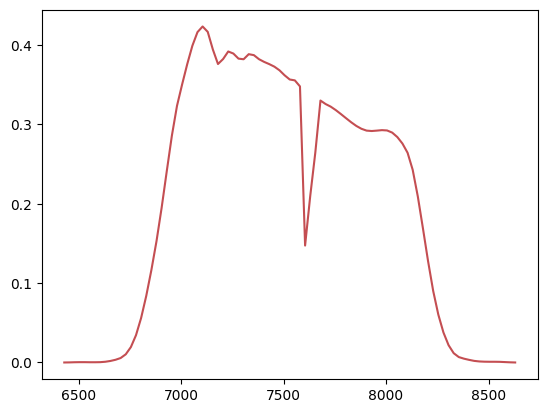

In [3]:
import polars

data = polars.read_csv('sdss_i.csv', comment_prefix='#')
print('# lines:', data.height)
print(data.head(5))

_ = plt.plot(data['WAVELENGTH'], data['THROUGHPUT'], 'r-')

The resulting structure is called a `DataFrame` and contains 89 rows and 2 columns. Note that Polars has inferred the data types of the columns and set them both to `float64`. This is probably excessive so let's cast everything to `float32` just to see how to do it:

In [4]:
data = data.cast(polars.Float32)
print(data.dtypes)

[Float32, Float32]


Given a dataframe there are a number of operations that we can perform on it (the nomenclature is not always the same so you may find different names for the same operation in different libraries):

- _Selection_: select a subset of the columns of the dataframe. Sometimes this also applies to rows when we are selecting them based on indexing.
- _Filtering_: select a subset of the rows of the dataframe based on some condition. For example, we may want to select only the rows where the value of a column is greater than a certain value.
- _Aggregation_: combine the values of a column based on some condition. For example, we may want to calculate the mean value of a column for all the rows that satisfy a certain condition.
- _Sorting_: sort the rows of the dataframe based on the values of one or more columns.
- _Grouping_: group the rows of the dataframe based on the values of one or more columns. For each group we can then apply an aggregation function to calculate a summary statistic (e.g., mean, median, etc.)
- _Pivoting_: transform the dataframe from a long format to a wide format or vice versa.
- _Joining_: combine two dataframes based on the values of one or more columns.

We will not explicitly try to cover all these operations here but we will see examples for many of them. Let's start with a simple aggregation by calculate the mean wavelength and throughput:

In [5]:
print(data.mean())

shape: (1, 2)
┌────────────┬────────────┐
│ WAVELENGTH ┆ THROUGHPUT │
│ ---        ┆ ---        │
│ f32        ┆ f32        │
╞════════════╪════════════╡
│ 7530.0     ┆ 0.19872    │
└────────────┴────────────┘


Note that the `mean()` operation, when applied to the entire dataframe, calculates the mean for each column. We can also calculate the mean for a single column by first selecting it using square brackets with the name of the column:

In [6]:
print('Mean throughput:', data['THROUGHPUT'].mean())

Mean throughput: 0.19872022421091726


Polars also provides a way to select a subset of columns using the `select()` method

In [7]:
print(data.select('WAVELENGTH'))

shape: (89, 1)
┌────────────┐
│ WAVELENGTH │
│ ---        │
│ f32        │
╞════════════╡
│ 6430.0     │
│ 6455.0     │
│ 6480.0     │
│ 6505.0     │
│ 6530.0     │
│ …          │
│ 8530.0     │
│ 8555.0     │
│ 8580.0     │
│ 8605.0     │
│ 8630.0     │
└────────────┘


We can apply a filter on the rows of the dataframe using the `filter()` method. For example, let's select only the rows where the wave;ength is greater than 8000 Angstroms:

In [8]:
print(data.filter(polars.col.WAVELENGTH > 8000))

shape: (26, 2)
┌────────────┬────────────┐
│ WAVELENGTH ┆ THROUGHPUT │
│ ---        ┆ ---        │
│ f32        ┆ f32        │
╞════════════╪════════════╡
│ 8005.0     ┆ 0.2923     │
│ 8030.0     ┆ 0.2896     │
│ 8055.0     ┆ 0.284      │
│ 8080.0     ┆ 0.2758     │
│ 8105.0     ┆ 0.2642     │
│ …          ┆ …          │
│ 8530.0     ┆ 0.0009     │
│ 8555.0     ┆ 0.0008     │
│ 8580.0     ┆ 0.0005     │
│ 8605.0     ┆ 0.0002     │
│ 8630.0     ┆ 0.0        │
└────────────┴────────────┘


Polars uses a special syntax to refer to the columns of the dataframe. In this case we are using `polars.col.WAVELENGTH` to refer to the `WAVELENGTH` column. This is call an _expression_ and internally Polars uses a query engine to evaluate the expression and apply it to the dataframe in the most efficient way.

## Reading and converting FITS files

Let's move to a more interesting example. The file `Kounkel_Clustering.fits` contains a catalogue of young stars in the Solar neighbourhood published in [Kounkel et al. (2019)(https://ui.adsabs.harvard.edu/abs/2019AJ....158..122K/abstract)] and selected from the [Gaia DR2](https://www.cosmos.esa.int/web/gaia/dr2) catalogue. The file is a FITS catalogue so we cannot read it directly with Polars or Pandas. Instead, we will use the [astropy.table](https://docs.astropy.org/en/stable/table/) module to read it.

In [9]:
from astropy.table import Table

table = Table.read('Kounkel_Clustering.fits')
print(table)

     SOURCE_ID            2mass       ...        DIST             EDIST       
------------------- ----------------- ... ----------------- ------------------
2172342682494385024 21221732+5204385  ... 655.3072337333102 30.594480041462198
2170224782576556672 21023648+5212011  ... 655.3072337333102 30.594480041462198
2168760576695182208 21025198+5013440  ... 655.3072337333102 30.594480041462198
2168760439256230528 21030325+5013130  ... 655.3072337333102 30.594480041462198
2170222343035098880 21021934+5204460  ... 655.3072337333102 30.594480041462198
2168971717281204352 21011130+5037403  ... 655.3072337333102 30.594480041462198
2169491648838088064 21053520+5138262  ... 655.3072337333102 30.594480041462198
2168944744886766208 21020077+5019449  ... 655.3072337333102 30.594480041462198
2168967009997150720 21014403+5029231  ... 655.3072337333102 30.594480041462198
2176086004195127808 21191303+5345457  ... 655.3072337333102 30.594480041462198
                ...               ... ...           

Astropy Table objects allows to perform many of the same operations that we saw before, such as filtering, selecting, or aggregation. You can read the documentation about how to do that, but in many cases it is similar to using Numpy on an array. Here we will just convert the table to a Polars dataframe; we just need to convert the table to a Numpy structure and then read it with Polars:

In [10]:
df = polars.DataFrame(table.as_array())
print(df)

shape: (987_376, 18)
┌────────────┬───────────┬───────────┬───────────┬───┬──────────┬──────────┬───────────┬───────────┐
│ SOURCE_ID  ┆ 2mass     ┆ RA        ┆ DEC       ┆ … ┆ AV       ┆ EAV      ┆ DIST      ┆ EDIST     │
│ ---        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---      ┆ ---      ┆ ---       ┆ ---       │
│ i64        ┆ binary    ┆ f64       ┆ f64       ┆   ┆ f64      ┆ f64      ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪══════════╪═══════════╪═══════════╡
│ 2172342682 ┆ b"2122173 ┆ 320.57220 ┆ 52.07734  ┆ … ┆ 1.157455 ┆ 0.199624 ┆ 655.30723 ┆ 30.59448  │
│ 494385024  ┆ 2+5204385 ┆ 4         ┆           ┆   ┆          ┆          ┆ 4         ┆           │
│            ┆ \x20"     ┆           ┆           ┆   ┆          ┆          ┆           ┆           │
│ 2170224782 ┆ b"2102364 ┆ 315.65202 ┆ 52.200351 ┆ … ┆ 1.157455 ┆ 0.199624 ┆ 655.30723 ┆ 30.59448  │
│ 576556672  ┆ 8+5212011 ┆ 9         ┆           ┆   ┆          ┆     

Note that the `2mass` column, a string column, has not been properly converted. This is a typical issue with FITS tables in which the Unicode strings are not properly handled. We can easily fix this and also show how to use the `.with_columns()` to create or replace columns by performing and operation on the existing columns. We'll also use it to rename all the columns to lowercase:

In [11]:
df = df.with_columns(polars.col('2mass').cast(polars.String))

# Rename all columns to lowercase
df = df.rename(lambda col: col.lower())
print(df)

shape: (987_376, 18)
┌────────────┬───────────┬───────────┬───────────┬───┬──────────┬──────────┬───────────┬───────────┐
│ source_id  ┆ 2mass     ┆ ra        ┆ dec       ┆ … ┆ av       ┆ eav      ┆ dist      ┆ edist     │
│ ---        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---      ┆ ---      ┆ ---       ┆ ---       │
│ i64        ┆ str       ┆ f64       ┆ f64       ┆   ┆ f64      ┆ f64      ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪══════════╪═══════════╪═══════════╡
│ 2172342682 ┆ 21221732+ ┆ 320.57220 ┆ 52.07734  ┆ … ┆ 1.157455 ┆ 0.199624 ┆ 655.30723 ┆ 30.59448  │
│ 494385024  ┆ 5204385   ┆ 4         ┆           ┆   ┆          ┆          ┆ 4         ┆           │
│ 2170224782 ┆ 21023648+ ┆ 315.65202 ┆ 52.200351 ┆ … ┆ 1.157455 ┆ 0.199624 ┆ 655.30723 ┆ 30.59448  │
│ 576556672  ┆ 5212011   ┆ 9         ┆           ┆   ┆          ┆          ┆ 4         ┆           │
│ 2168760576 ┆ 21025198+ ┆ 315.71659 ┆ 50.228894 ┆ … ┆ 1.157455 ┆ 0.19

The expression inside `rename()` is called a [lambda function](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) and is a way to define a function in a single line. In this case Polars will call it with the name of each column.

Let's see what columns we have in the dataframe:

In [12]:
print(df.columns)

['source_id', '2mass', 'ra', 'dec', 'parallax', 'id', 'g', 'bp', 'rp', 'j', 'h', 'k', 'age', 'eage', 'av', 'eav', 'dist', 'edist']


There are two columns that, in principle, should convey the same information: `parallax` is the [stellar parallax](https://en.wikipedia.org/wiki/Parallax) in milliarcseconds for the source, and `dist` is the distance to the star in parsecs. The distance can be calculated from the parallax using the formula:

$$
d = \frac{1}{p}
$$

where $d$ is the distance in parsecs and $p$ is the parallax in arcseconds. Let's add two columns to our dataframe. The first one will be the distance calculated from the parallax (we'll call it `dist_parallax`), and the second one will be the difference between `distance_parallax` and `dist` (we'll call it `dist_diff`).

In [13]:
df = df.with_columns(
    dist_parallax = (1 / (polars.col.parallax / 1000))
).with_columns(
    dist_diff = abs(polars.col.dist_parallax - polars.col.dist)
)

print(df.select(polars.col('source_id', 'dist', 'parallax', 'dist_parallax', 'dist_diff')))

shape: (987_376, 5)
┌─────────────────────┬─────────────┬──────────┬───────────────┬────────────┐
│ source_id           ┆ dist        ┆ parallax ┆ dist_parallax ┆ dist_diff  │
│ ---                 ┆ ---         ┆ ---      ┆ ---           ┆ ---        │
│ i64                 ┆ f64         ┆ f32      ┆ f32           ┆ f64        │
╞═════════════════════╪═════════════╪══════════╪═══════════════╪════════════╡
│ 2172342682494385024 ┆ 655.307234  ┆ 1.682965 ┆ 594.189453    ┆ 61.117781  │
│ 2170224782576556672 ┆ 655.307234  ┆ 1.68418  ┆ 593.760742    ┆ 61.546492  │
│ 2168760576695182208 ┆ 655.307234  ┆ 1.699172 ┆ 588.52179     ┆ 66.785444  │
│ 2168760439256230528 ┆ 655.307234  ┆ 1.599939 ┆ 625.023987    ┆ 30.283247  │
│ 2170222343035098880 ┆ 655.307234  ┆ 1.909109 ┆ 523.804565    ┆ 131.502668 │
│ …                   ┆ …           ┆ …        ┆ …             ┆ …          │
│ 533346328699090432  ┆ 1165.741721 ┆ 0.644998 ┆ 1550.392578   ┆ 384.650857 │
│ 533016818809105792  ┆ 1165.741721 ┆ 0.9235

We have used `with_columns()` twice to add the two columns since we need to use the value of the first column to calculate the second one. This is sometimes called _chaining_ and is a common pattern in data science libraries.

Let's now create a histogram of the distance difference.

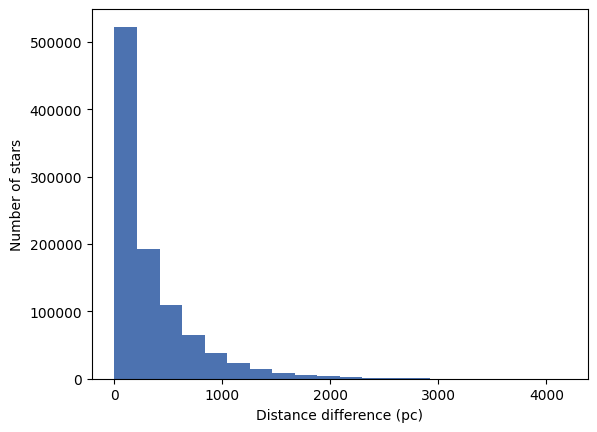

In [14]:
_ = plt.hist(df['dist_diff'], bins=20)
_ = plt.xlabel('Distance difference (pc)')
_ = plt.ylabel('Number of stars')

We see that a majority of the stars have a small distance difference but with a long tail. This tells us that the procedure used by the authors to calculate the distance took more than just the parallax into account.

We can also create an H-R diagram of the stars in the catalogue. The table includes the G, BP, and RP magnitudes for each star (these are all Gaia filters). For an H-R diagram we need to calculate the absolute magnitude of one of those filters (to act as a proxy for the luminosity). The effective temperature can be estimated from a colour (for example the difference between BP and RP). Since we know the distance, the absolute magnitude can be calculated from the apparent magnitude using the formula:

$$
M_G = m_G - 5 \cdot (log_{10}(d) - 1)
$$

where $M_G$ is the absolute magnitude, $m_G$ is the apparent G magnitude, and $d$ is the distance in parsecs. We will use the [seaborn](https://seaborn.pydata.org/) library to create the H-R diagram using a histogram plot as we will see in more detail in the [next section](#data-visualisation).

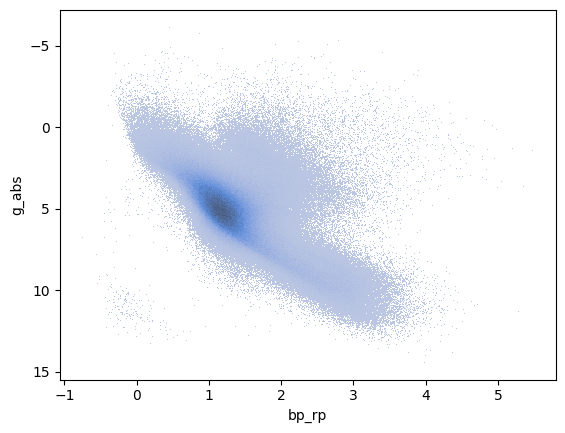

In [15]:
import seaborn

df = df.with_columns(
    g_abs = polars.col.g - 5 * (polars.col.dist.log10() - 1),
    bp_rp = polars.col.bp - polars.col.rp
)

_ = seaborn.histplot(data=df,x='bp_rp', y='g_abs')
plt.gca().invert_yaxis()  # Typically we want to invert the y-axis in H-R diagrams

We only see the main sequence here since all these stars are fairly young and most have not evolved to giants yet. In fact, we can sort this table by age (really the $\log_{10}$ of the age in years):

In [16]:
df = df.sort('age')
print(df.select(polars.col('source_id', 'age')))

shape: (987_376, 2)
┌─────────────────────┬──────────┐
│ source_id           ┆ age      │
│ ---                 ┆ ---      │
│ i64                 ┆ f64      │
╞═════════════════════╪══════════╡
│ 5975543331278657408 ┆ 6.1192   │
│ 5975543335568508416 ┆ 6.1192   │
│ 5975462487104040448 ┆ 6.1192   │
│ 5975542579654256640 ┆ 6.1192   │
│ 5975518832773727360 ┆ 6.1192   │
│ …                   ┆ …        │
│ 533346328699090432  ┆ 9.776571 │
│ 533016818809105792  ┆ 9.776571 │
│ 532824507352258560  ┆ 9.776571 │
│ 532498777032261120  ┆ 9.776571 │
│ 535655784151981696  ┆ 9.776571 │
└─────────────────────┴──────────┘


Finally, lets save this dataframe as a Parquet file.

In [17]:
df.write_parquet('Kounkel_Clustering.parquet')

## Working with time series

Let's look at a third dataset, `daily-min-temperatures.csv`, which contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.

In [18]:
!head -20 daily-min-temperatures.csv




















"1981-01-19",17.7


We'll start by loading with Polars and then convert the `Date` column to a datetime object.

In [19]:
df = polars.read_csv('daily-min-temperatures.csv')
df = df.with_columns(polars.col.Date.str.to_datetime())
print(df.head(5))

shape: (5, 2)
┌─────────────────────┬──────┐
│ Date                ┆ Temp │
│ ---                 ┆ ---  │
│ datetime[μs]        ┆ f64  │
╞═════════════════════╪══════╡
│ 1981-01-01 00:00:00 ┆ 20.7 │
│ 1981-01-02 00:00:00 ┆ 17.9 │
│ 1981-01-03 00:00:00 ┆ 18.8 │
│ 1981-01-04 00:00:00 ┆ 14.6 │
│ 1981-01-05 00:00:00 ┆ 15.8 │
└─────────────────────┴──────┘


We note a couple things: first, we have used the `.str` accessor to apply a function (`to_datetime()`) that only works on string columns; and when we use `with_columns()` but do not specify the name of the new column, Polars will use the name of the column we are modifying, overwriting it.

Noe that the `Date` column is a datetime object we have a real _time-series_ dataset and we can use the `dt` accessor to apply functions that only work on datetime objects. To begin with, let's just plot the data:

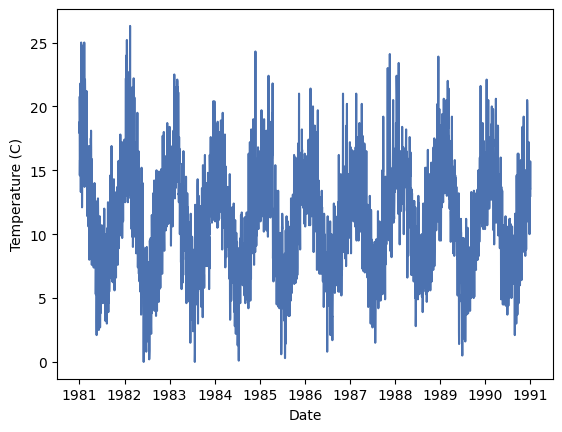

In [20]:
_ = plt.plot(df['Date'], df['Temp'])
_ = plt.xlabel('Date')
_ = plt.ylabel('Temperature (C)')

Th data shows a clear seasonal pattern, but also a lot of noise due to the day-to-day normal variations. We can use a [rolling mean](https://en.wikipedia.org/wiki/Moving_average) to smooth the data and see the seasonal pattern more clearly. A rolling mean is calculated by taking the mean of a number of consecutive values in the time series. For example, if we take a rolling mean of 7 days, we will take the mean of the first 7 days, then the mean of days 2 to 8, and so on. In this case we will average every 15 days.

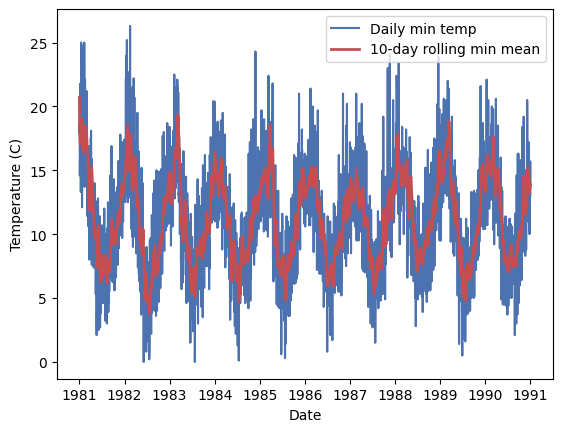

In [21]:
df = df.with_columns(min_mean=polars.col.Temp.rolling_mean_by(by='Date', window_size='15d'))

_ = plt.plot(df['Date'], df['Temp'], 'b-', label='Daily min temp')
_ = plt.plot(df['Date'], df['min_mean'], 'r-', lw=2, label='10-day rolling min mean')

_ = plt.legend()
_ = plt.xlabel('Date')
_ = plt.ylabel('Temperature (C)')

The [rolling_mean_by()](https://docs.pola.rs/api/python/stable/reference/expressions/api/polars.Expr.rolling_mean_by.html) function is just one of many provided by Polars. You can check the documentation to understand how to use it.

This dataset contains repeated measurements for each day of the year for 10 years. We can use this to calculate the average temperature for each day of the year. This will help us introduce the concept of _grouping_.

In [22]:
# Add a column with the day of the year
df = df.with_columns(day_of_year=polars.col.Date.dt.ordinal_day())

# Group data by day of the year and calculate the mean temperature.
df_grouped = df.group_by(
    polars.col.day_of_year
).agg(
    polars.col.Temp.mean().alias('daily_mean')
).sort('day_of_year')

print(df_grouped)

shape: (365, 2)
┌─────────────┬────────────┐
│ day_of_year ┆ daily_mean │
│ ---         ┆ ---        │
│ i16         ┆ f64        │
╞═════════════╪════════════╡
│ 1           ┆ 15.85      │
│ 2           ┆ 15.28      │
│ 3           ┆ 14.69      │
│ 4           ┆ 14.04      │
│ 5           ┆ 13.85      │
│ …           ┆ …          │
│ 361         ┆ 13.6       │
│ 362         ┆ 13.01      │
│ 363         ┆ 13.64      │
│ 364         ┆ 15.55      │
│ 365         ┆ 15.62      │
└─────────────┴────────────┘


The `group_by()` method creates groups of rows that share the same value for the group-by column. Then `agg()` applies the mean function to the `Temp` column for each group. The result is a new dataframe with the group-by columns and the aggregated columns. Let's convert back from the day of the year to a date (with an arbitrary year) and plot the result:

In [23]:
# Start by adding a column in which all the dates are the first day of the year 1980
df_grouped = df_grouped.with_columns(date=polars.lit('1980-01-01', dtype=polars.Date()) )

# Now add the day of the year as a time delta (minus one day since we start at 1)
df_grouped = df_grouped.with_columns(
    date=polars.col.date + polars.duration(days=polars.col.day_of_year - 1)
)
print(df_grouped)

shape: (365, 3)
┌─────────────┬────────────┬────────────┐
│ day_of_year ┆ daily_mean ┆ date       │
│ ---         ┆ ---        ┆ ---        │
│ i16         ┆ f64        ┆ date       │
╞═════════════╪════════════╪════════════╡
│ 1           ┆ 15.85      ┆ 1980-01-01 │
│ 2           ┆ 15.28      ┆ 1980-01-02 │
│ 3           ┆ 14.69      ┆ 1980-01-03 │
│ 4           ┆ 14.04      ┆ 1980-01-04 │
│ 5           ┆ 13.85      ┆ 1980-01-05 │
│ …           ┆ …          ┆ …          │
│ 361         ┆ 13.6       ┆ 1980-12-26 │
│ 362         ┆ 13.01      ┆ 1980-12-27 │
│ 363         ┆ 13.64      ┆ 1980-12-28 │
│ 364         ┆ 15.55      ┆ 1980-12-29 │
│ 365         ┆ 15.62      ┆ 1980-12-30 │
└─────────────┴────────────┴────────────┘


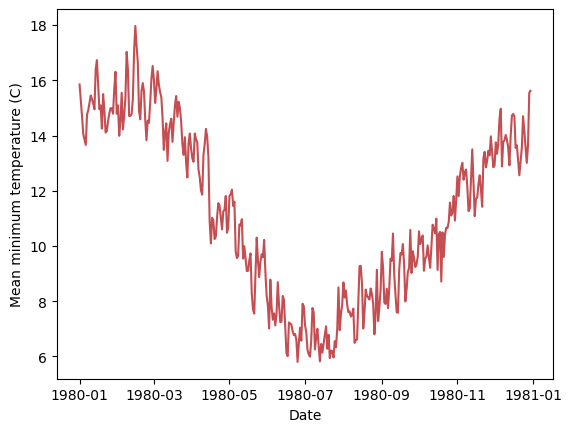

In [24]:
_ = plt.plot(df_grouped['date'], df_grouped['daily_mean'], 'r-')
_ = plt.xlabel('Date')
_ = plt.ylabel('Mean minimum temperature (C)')

## Relational database and SQL

Coming soon.

## Further reading

- [Tidy data](https://vita.had.co.nz/papers/tidy-data.pdf) by Hadley Wickham
- [Introduction to SQL](https://ntrs.nasa.gov/api/citations/20080040136/downloads/20080040136.pdf)